<a href="https://colab.research.google.com/github/carsonnj/Project-4---Store-Sales-ML/blob/main/Copy_of_Store_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
from sklearn.cluster import KMeans
from pathlib import Path
!pip install hvplot
import hvplot.pandas
!pip install holoviews
import holoviews as hv
from holoviews import opts


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.9 MB/s eta 0:00:00


In [2]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

import findspark
findspark.init()
from pyspark.sql import SparkSession

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [736 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,951 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/

In [3]:
store_sales_df = pd.read_csv("https://raw.githubusercontent.com/carsonnj/Project-4---Store-Sales-ML/main/Stores.csv")
store_sales_df.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1,1659,1961,530,66490
1,2,1461,1752,210,39820
2,3,1340,1609,720,54010
3,4,1451,1748,620,53730
4,5,1770,2111,450,46620


In [4]:
# Convert Store_Area from square yards to square feet
yards_to_ft = 9
store_sales_df['sq_ft'] = store_sales_df['Store_Area'] * yards_to_ft

# Display the first five rows of the dataframe
store_sales_df.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,sq_ft
0,1,1659,1961,530,66490,14931
1,2,1461,1752,210,39820,13149
2,3,1340,1609,720,54010,12060
3,4,1451,1748,620,53730,13059
4,5,1770,2111,450,46620,15930


In [5]:
#Divide Sales/sq. feet for sales $ per sq. ft
store_sales_df['sales_per_sq_ft'] = store_sales_df['Store_Sales'] / store_sales_df['sq_ft']
#Show df
store_sales_df.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,sq_ft,sales_per_sq_ft
0,1,1659,1961,530,66490,14931,4.453151
1,2,1461,1752,210,39820,13149,3.028367
2,3,1340,1609,720,54010,12060,4.478441
3,4,1451,1748,620,53730,13059,4.114404
4,5,1770,2111,450,46620,15930,2.926554


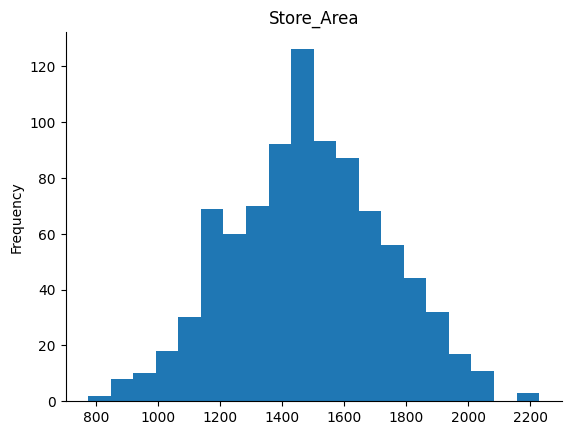

In [6]:
#Store Area Distributions

from matplotlib import pyplot as plt
store_sales_df['Store_Area'].plot(kind='hist', bins=20, title='Store_Area')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
#Divide Sales/sq. feet for sales $ per sq. ft
store_sales_df['sales_per_customer'] = store_sales_df['Store_Sales'] / store_sales_df['Daily_Customer_Count']
#Show df
store_sales_df.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,sq_ft,sales_per_sq_ft,sales_per_customer
0,1,1659,1961,530,66490,14931,4.453151,125.452830
1,2,1461,1752,210,39820,13149,3.028367,189.619048
2,3,1340,1609,720,54010,12060,4.478441,75.013889
3,4,1451,1748,620,53730,13059,4.114404,86.661290
4,5,1770,2111,450,46620,15930,2.926554,103.600000


Clustering Model

In [9]:
 # Create a a list to store inertia values and the values of k
inertia = []
k = list(range(1, 11))
 # Create a for-loop where each value of k is evaluated using the K-means algorithm
# Fit the model using the service_ratings DataFrame
# Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, random_state=1)
    k_model.fit(store_sales_df)
    inertia.append(k_model.inertia_)
# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

,k,inertia
0,1,2.693146e+11
1,2,8.865954e+10
2,3,4.903793e+10
3,4,3.151638e+10
4,5,2.314668e+10


from matplotlib import pyplot as plt
_df_0['k'].plot(kind='hist', bins=20, title='k')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['inertia'].plot(kind='hist', bins=20, title='inertia')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='k', y='inertia', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['k']
  ys = series['inertia']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('k', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('k')
_ = plt.ylabel('inertia')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['k']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'k'}, axis=1)
              .sort_values('k', ascending=True))
  xs = counted['k']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('k', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('k')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['k'].plot(kind='line', figsize=(8, 4), title='k')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['inertia'].plot(kind='line', figsize=(8, 4), title='inertia')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['k']
  ys = series['inertia']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('k', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('k')
_ = plt.ylabel('inertia')

In [10]:
# Plot the DataFrame
df_elbow.hvplot.line(
    x="k",
    y="inertia",
    title="Elbow Curve",
    xticks=k
)


:Curve   [k]   (inertia)

In [11]:
# Define the model with the lower value of k clusters
# Use a random_state of 1 to generate the model
model = KMeans(n_clusters=4, random_state=1)

# Fit the model
model.fit(store_sales_df)

# Make predictions
k_lower = model.predict(store_sales_df)

# Create a copy of the DataFrame
store_sales_cluster_df = store_sales_df.copy()

# Add a class column with the labels to the spread_df_predictions DataFrame
store_sales_cluster_df['cluster_number'] = k_lower

#Print prediction
store_sales_cluster_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,sq_ft,sales_per_sq_ft,sales_per_customer,cluster_number
0,1,1659,1961,530,66490,14931,4.453151,125.452830,0
1,2,1461,1752,210,39820,13149,3.028367,189.619048,3
2,3,1340,1609,720,54010,12060,4.478441,75.013889,2
3,4,1451,1748,620,53730,13059,4.114404,86.661290,2
4,5,1770,2111,450,46620,15930,2.926554,103.600000,2


In [12]:
#Start Spark Session
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
# Create a SparkSession object
spark = SparkSession.builder.getOrCreate()
# Create a DataFrame from the existing store_sales_cluster_df variable
store_sales_cluster_df = spark.createDataFrame(store_sales_cluster_df)
#create temp table to use spark.sql to understand cluster
store_sales_cluster_df.createOrReplaceTempView("cluster")
#group by cluster and look at average sales, sq. ft, and sales per sq. ft
store_sales_cluster_df.groupBy("cluster_number").agg(avg("Store_Sales"), avg("Sq_Ft"), avg("Sales_Per_Sq_Ft"), avg("Items_Available"), avg("Daily_Customer_Count"), avg("sales_per_customer")).show()

+--------------+-----------------+------------------+--------------------+--------------------+-------------------------+-----------------------+
|cluster_number| avg(Store_Sales)|        avg(Sq_Ft)|avg(Sales_Per_Sq_Ft)|avg(Items_Available)|avg(Daily_Customer_Count)|avg(sales_per_customer)|
+--------------+-----------------+------------------+--------------------+--------------------+-------------------------+-----------------------+
|             0|67154.18604651163|13492.186046511628|   5.114403095059547|   1798.562015503876|        780.9302325581396|     103.43709101469265|
|             1|84296.14942528735| 13721.48275862069|  6.3586799107986565|  1829.6436781609195|        794.0229885057471|     126.49744127508733|
|             3|36290.54347826087|12944.152173913044|    2.88759252218847|  1724.8641304347825|        777.8804347826087|      54.43010570474268|
|             2|51814.28571428572|13314.632142857143|   4.011114506891602|  1774.7928571428572|        792.1428571428571|   

In [13]:
store_sales_df.describe()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,sq_ft,sales_per_sq_ft,sales_per_customer
count,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000
mean,448.500000,1485.409598,1782.035714,786.350446,59351.305804,13368.686384,4.553968,94.043175
std,258.797218,250.237011,299.872053,265.389281,17190.741895,2252.133099,1.522267,162.819099
min,1.000000,775.000000,932.000000,10.000000,14920.000000,6975.000000,1.231475,15.070707
25%,224.750000,1316.750000,1575.500000,600.000000,46530.000000,11850.750000,3.451944,55.875573
50%,448.500000,1477.000000,1773.500000,780.000000,58605.000000,13293.000000,4.420069,75.409239
75%,672.250000,1653.500000,1982.750000,970.000000,71872.500000,14881.500000,5.414897,102.853319
max,896.000000,2229.000000,2667.000000,1560.000000,116320.000000,20061.000000,10.701001,4548.000000


Feature Engineering to Optimize models

In [ ]:
# copy DF
store_sales_copy_df = store_sales_df.copy()
#Remove stores with less than 100 daily customerss
store_sales_copy_df = store_sales_copy_df[store_sales_copy_df['Daily_Customer_Count'] >= 250]

store_sales_copy_df.describe()


Linear Regression Model


In [17]:
from sklearn.model_selection import train_test_split
# Extract features (X) and target variable (y)
X = store_sales_df[['Items_Available', 'sq_ft', 'Daily_Customer_Count']]
y = store_sales_df['Store_Sales']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
 print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

NameError: name 'classifier' is not defined

In [18]:
# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
# Visualize predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Store Sales')
plt.ylabel('Predicted Store Sales')
plt.title('Actual vs. Predicted Store Sales')
plt.show()

In [ ]:
import numpy as np
mse = mean_squared_error(y_test, xgbr_pred)
rmse = np.sqrt(mean_squared_error(y_test, xgbr_pred))

score = xgbr.score(X_train, y_train)
r2 =r2_score(y_test,  xgbr_pred)

In [ ]:
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (rmse))
print("Training score: ", score)
print("R_score : %.2f"%(r2))

XGBoost Model

In [ ]:
# Models
from xgboost.spark import SparkXGBRegressor
import xgboost as xgb
from xgboost import XGBRegressor

In [ ]:
from sklearn.model_selection import train_test_split
# Extract features (X) and target variable (y)
X = store_sales_df[['Items_Available', 'sq_ft', 'Daily_Customer_Count']]
y = store_sales_df['Store_Sales']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


LinearRegression()

In [ ]:
xgbr = XGBRegressor(random_state = 116)
xgbr.fit(X_train, y_train)
xgbr_pred =xgbr.predict(X_test)

In [ ]:
import numpy as np
mse = mean_squared_error(y_test, xgbr_pred)
rmse = np.sqrt(mean_squared_error(y_test, xgbr_pred))

score = xgbr.score(X_train, y_train)
r2 =r2_score(y_test,  xgbr_pred)

In [ ]:
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (rmse))
print("Training score: ", score)
print("R_score : %.2f"%(r2))

KNN Model

In [ ]:
from sklearn.model_selection import train_test_split
# Extract features (X) and target variable (y)
X = store_sales_df[['Items_Available', 'sq_ft', 'Daily_Customer_Count']]
y = store_sales_df['Store_Sales']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


LinearRegression()

In [ ]:
# Build the neural network model
model = Sequential()
model.add(Dense(64, input_dim=3, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))


In [ ]:
 print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

In [ ]:
# Visualize training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)
# Visualize predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Store Sales')
plt.ylabel('Predicted Store Sales')
plt.title('Actual vs. Predicted Store Sales')
plt.show()

Linear Regression Model with Multi variables

In [ ]:
#build machine learning with multiple variable linear regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define features and target variable
X = store_sales_copy_df[['Items_Available', 'sq_ft', 'Daily_Customer_Count']]
y = store_sales_copy_df['Store_Sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)



In [ ]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean squared error: {mse}")
print(f"R2 score: {r2}")

# Coefficients of the model
coefficients = model.coef_
intercept = model.intercept_

print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")

# Plot the actual and predicted values
plt.scatter(y_test, y_pred)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.show()